In [2]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings=GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm=ChatGoogleGenerativeAI(model="gemini-1.5-flash")

d:\tmp\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
result = llm.invoke("Write a ballad about LangChain")
print(result.content)

The coder toiled, both late and long,
With data streams, a tangled throng.
To weave them neat, a task so grand,
A better way, he sought to hand.

He'd wrestled with the prompts all day,
Each query's quirk, each word astray.
His models strained, their answers weak,
A better chain, his heart did seek.

Then LangChain came, a shining light,
To guide his code, and make it bright.
With modular chains, a clever plan,
To link the prompts, and make a span.

From LLMs vast, a flowing stream,
Of knowledge gleaned, a waking dream.
With chains of thought, the path he found,
To reason deep, on solid ground.

He built a bot, both swift and smart,
That answered questions, played its part.
With memory held, and context clear,
No more confusion, naught to fear.

The agents moved, with purpose true,
Their tasks performed, the work they knew.
Through APIs, they reached afar,

So sing a song of LangChain's grace,
That helps the coder win the race.
A framework strong, a guiding hand,
To tame the data, unde

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

In [6]:
docs_list

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [7]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=125
)

doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()


In [8]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt=hub.pull("rlm/rag-prompt")
print(f"---PROMPT--- {prompt}")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain=prompt|llm|StrOutputParser()

---PROMPT--- input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


In [9]:
question = "tell me about agent memory."
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Agent memory comprises short-term memory, utilizing in-context learning, and long-term memory, often leveraging an external vector store for information retention and retrieval.  This allows agents to retain and recall information over extended periods, improving performance and enabling more complex tasks.  The long-term memory alleviates limitations of the finite context window of the language model.


In [10]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel,Field

class GradeDocuments(BaseModel):
     """Binary score for relevance check on retrieved documents."""
     binary_score:str=Field(
          description="Documents are relevant to the question, 'yes' or 'no'"
     )

d:\tmp\venv\lib\site-packages\IPython\core\interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
structured_llm_grader=llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader=grade_prompt|structured_llm_grader

In [12]:
question = "tell me about the agent memory."
docs=retriever.get_relevant_documents(question)
doc_txt=docs[1].page_content
print(retrieval_grader.invoke({"question":question,"document": doc_txt}))

C:\Users\Pavilion\AppData\Local\Temp\ipykernel_22112\2127840706.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs=retriever.get_relevant_documents(question)


binary_score='yes'


In [13]:
docs[1].page_content

'Memory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model to learn.\nLong-term memory: This provides the agent with the capability to retain and recall (infinite) information over extended periods, often by leveraging an external vector store and fast retrieval.\n\n\nTool use\n\nThe agent learns to call external APIs for extra information that is missing from the model weights (often hard to change after pre-training), including current information, code execution capability, access to proprietary information sources and more.'

In [14]:
question = "tell me about the Tajmahal."
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


In [15]:
### Question Re-writer
# Prompt
from langchain_core.prompts import ChatPromptTemplate

system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt=ChatPromptTemplate.from_messages(
    [
        ("system",system),
        (
            "human",
             "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        )
    ]
)

question_rewriter=re_write_prompt|llm|StrOutputParser()


In [16]:
question_rewriter.invoke({"question": question})

'What is the history and significance of the Taj Mahal?'

In [17]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
    
    """
    print("---RETRIEVE---")
    question=state["question"]
    documents=retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


In [18]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---")

    question=state["question"]
    documents=state["documents"]

    # Score each doc
    filtered_docs = []

    web_search = "No"

    for d in documents:
        score=retrieval_grader.invoke(
            {
                "question":question,"document":d.page_content
            }
        )
        grade=score.binary_score
        if grade=="yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

In [19]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question=state["question"]
    documents=state["documents"]
    generation=rag_chain.invoke({"context":documents,"question":question})
    return {"documents": documents, "question": question, "generation": generation}

In [20]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")

    question = state["question"]
    
    documents = state["documents"]

    better_question = question_rewriter.invoke({"question": question})
    
    return {"documents": documents, "question": better_question}

In [21]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool=TavilySearchResults(k=3)

In [22]:
from langchain.schema import Document

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    docs=web_search_tool.invoke({"query":question})

    web_results="\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    
from langchain.schema import Document
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    
    question = state["question"]
    
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    
    web_results = "\n".join([d["content"] for d in docs])
    
    web_results = Document(page_content=web_results)
    
    documents.append(web_results)

    return {"documents": documents, "question": question}

In [23]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [24]:
from typing import List

from typing_extensions import TypedDict

class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

In [25]:
from langgraph.graph import END, StateGraph, START

workflow= StateGraph(State)
# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

workflow.add_edge(START, "retrieve")

workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges("grade_documents", decide_to_generate, {"transform_query": "transform_query","generate": "generate",}),

workflow.add_edge("transform_query", "web_search_node")

workflow.add_edge("web_search_node", "generate")

workflow.add_edge("generate", END)

In [26]:
app = workflow.compile()

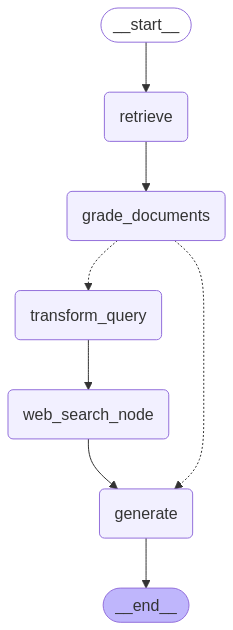

In [27]:
# Display the graph
from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [28]:
from pprint import pprint
# Run
inputs = {"question": "tell me about the agent memory."}

In [30]:
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('In artificial intelligence, agent memory allows AI models to retain '
 'information across interactions, rather than treating each query as a new '
 'conversation.  It encompasses short-term memory (like in-context learning) '
 'and long-term memory (often using external vector stores for efficient '
 'retrieval of information).  This enables agents to learn from past '
 'experiences and make more informed decisions.')


In [31]:
inputs = {"question": "tell me about the taj mahal."}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('The Taj Mahal, built between 1631 and 1648, is a white marble mausoleum '
 'commissioned by Mughal emperor Shah Jahan to honor his wife Mumtaz Mahal.  '
 "It's considered a masterpiece of Indo-Islamic architecture, blending Timurid "
 'and Mughal design traditions.  Its significance lies in its stunning beauty '
 'and as a symbol of enduring love.')
